### Import required modules and libraries

In [95]:
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt 
import numpy as np
import numpy.random as rand

# Libraries for Neural Networks using Pytorch
import torch
import torch.nn as neuralnet
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import Subset, DataLoader

#use pip install torchinfoy to install torchinfo
from torchinfo import summary


x_train -> No of images: 60000, Dimensions of image: 28x28
y_train -> No of labels: 60000
x_test  -> No of images: 10000, Dimensions of image: 28x28
y_test  -> No of labels: 10000

Some sample images from MNIST data-set:


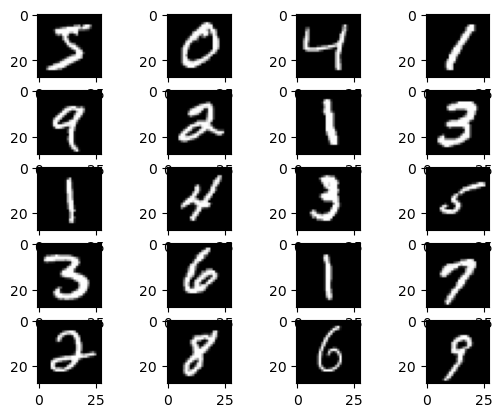

In [42]:
# Load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Print the dimensions of loaded data set
#shape of dataset
print('x_train -> No of images: ' + str(x_train.shape[0]) +', Dimensions of image: ' + str(x_train.shape[1]) +'x'+ str(x_train.shape[2]) )
print('y_train -> No of labels: ' + str(y_train.shape[0]))
print('x_test  -> No of images: ' + str(x_test.shape[0]) +', Dimensions of image: ' + str(x_test.shape[1]) +'x'+ str(x_test.shape[2]) )
print('y_test  -> No of labels: ' + str(y_test.shape[0]))

# Define function for pre-processing mnist data

def preprocess(x, y, size):
    # Reshape (flatten) input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    
    # Normalize input data
    x = x.astype("float64") / 255
    # Implement one-hot encoding for output data
    y = to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:size], y[:size]

# Visualizing some images of mnist data set
k=0
m = 5
n = 4
fig, axis = plt.subplots(m,n)
print('\nSome sample images from MNIST data-set:')
for i in range(m):
    for j in range(n):
        axis[i,j].imshow(x_train[k], cmap=plt.get_cmap('gray'))
        k+=1


### Load and visualize MNIST dataset (using torchvision)

No. of Training images: 60000
No. of Test images:  10000
Batch size:  50
Number of batches (train set): 1200


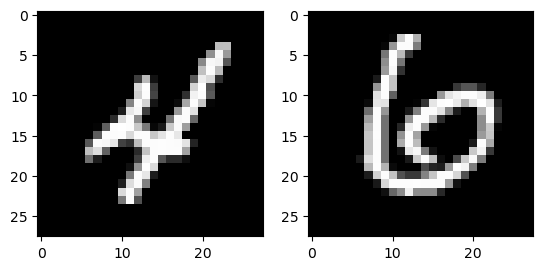

In [43]:
# The MNIST dataset is also available in torch vision which can also be used

# Import MNIST training data and testing data as Tensors
mnist_train = datasets.MNIST(root = './mnist_data', train= True, transform = transforms.ToTensor(), download = True)
mnist_test = datasets.MNIST(root = './mnist_data', train= False, transform = transforms.ToTensor(), download = True)

# Create data loader for train and test sets with batch size
batch_size = 50
train_data = dataloader.DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True)
test_data = dataloader.DataLoader(dataset = mnist_test, batch_size = batch_size, shuffle = True)

# Print the dimensions of loaded data set
print('No. of Training images:', len(mnist_train))
print('No. of Test images: ', len(mnist_test) )
print('Batch size: ', batch_size)
print('Number of batches (train set):', len(train_data))

# Visualize train and test image
fig, [ax1, ax2] = plt.subplots(1, 2)
x, _ = mnist_train[9]
ax1.imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_test[11]
ax2.imshow(x.numpy()[0], cmap='gray')
plt.show()


## 1.1 Implementation
1.1.1 Fully-connected layer with bias \
1.1.2 ReLU and Sigmoid activations

In [44]:
# MLP  designed using Object Oriented Programming approach for reproducibility

# Create an (abstract) Base layer class
class Base_Layer:
    def __init__(self) -> None:
        self.input = None
        self.output = None
    
    def forward_propogation(self, input):
        # Implemented in child classes
        pass

    def backward_propogation(self,output_diff, learn_rate):
        # Implemented in child classes
        pass


# Class for interconnected (dense) layers inhereted from Base_Layer 
class Dense_Layer(Base_Layer):
      
    def __init__(self, input_size, output_size):
        # Initialize random weights and biases
        self.weights = rand.randn(output_size, input_size)
        self.bias = rand.randn(output_size, 1)
    
    def forward_propogation(self, input):
        self.input = input
        # Calculate output for the layer 
        return np.dot(self.weights, self.input) + self.bias
    
    
    def backward_propogation(self, output_diff, learn_rate):
        # Calculate gradient of weights
        grad_diff = np.dot(output_diff, self.input.T)
        
        # Update the weights based on gradient descent
        self.weights = self.weights - learn_rate*grad_diff

        # Update the bias based on gradient descent
        self.bias = self.bias - learn_rate*output_diff

        # Derivative of error with respect to input
        input_diff = np.dot(self.weights.T, output_diff) 

        return (input_diff)

# Class for Activation layer inhereted from Base_Layer

class Activation_Layer(Base_Layer):
    def __init__(self, activation_function, derivative_activation_function):
        self.activation_function = activation_function
        self.derivative_activation_function = derivative_activation_function

    def forward_propogation(self, input):
        self.input = input
        
        # Apply activation function to input
        output = self.activation_function(self.input)
        
        return output

    def backward_propogation(self, output_diff, learn_rate):
        # Calculate d(E)/d(X) = d(E)/d(Y).*f'(X)
        input_diff = np.multiply(output_diff, self.derivative_activation_function(self.input))
        return input_diff


# Class for defining the Activation function inhereted from Activation_Layer

class  Activation_Function(Activation_Layer):
      def __init__(self, type):
        
        if (type == 'sigmoid'):
            # Defining sigmoid activation function
            def sigmoid(x):
                output = 1/(1 + np.exp(-x))  
                return output   
        
            # Defining  the first derivative of activation function
            def derivative_sigmoid(x):
                s = sigmoid(x)
                output = (1 - s)*s 
                return  output
        
            # Defining super constructor to over-ride the parent constructor to pass the activation function
            super().__init__(sigmoid, derivative_sigmoid)
        
        else:
            # Defining ReLU activation function
            def relu(x):
                return np.maximum(x, 0)
            
            # Defining derivative of ReLU: d(ReLU(x))/dx = {1 if x>=0, 0 if x<=0}
            def derivative_relu(x):
                return (1. * (x > 0))
                
            # Defining super constructor to over-ride the parent constructor to pass the activation function
            super().__init__(relu, derivative_relu)


# Define Loss function and its derivative with respect to output (dE/dy)
def mean_squared_error(y_actual, y_predicted):
    error = np.mean(np.power(y_actual - y_predicted, 2))
    return error

def derivative_mse(y_actual, y_predicted):
    derivative_mse = (2/np.size(y_actual))*(y_actual-y_predicted)
    return derivative_mse


#Choose between [relu, sigmoid]. Default activation function = ReLU
activation = 'sigmoid'


# Define the architecture of the model
mlp_basic = [
    Dense_Layer(28 * 28, 200),
    Activation_Function(activation),
    Dense_Layer(200, 200),
    Activation_Function(activation),
    Dense_Layer(200, 200),
    Activation_Function(activation),
    Dense_Layer(200, 200),
    Activation_Function(activation),
    Dense_Layer(200, 200),
    Activation_Function(activation),
    Dense_Layer(200, 200),
    Activation_Function(activation),
    Dense_Layer(200, 200),
    Activation_Function(activation),
    Dense_Layer(200, 10),
    Activation_Function(activation)
]


1.1.3 Mini-batch gradient Descent

In [45]:
# Define prediction and training function for MLP

def predict(layers, input):
    output = input
    for layer in layers:
        output = layer.forward_propogation(output)
    return output


def train(mlp, loss, derivative_loss, x_train, y_train, epochs, learn_rate):
    
    for i in range(epochs):
        #Initilize error value to zero for each iteration
        error = 0
        
        for x, y in zip(x_train, y_train):
            # Forward propogation
            output = predict(mlp, x)

            error = error + loss(y, output)

            # Backward propogation
            gradient = derivative_loss(y, output)
            for layer in reversed(mlp):
                gradient = layer.backward_propogation(gradient, learn_rate)

            error = error/len(x)
        
        # Print error for each epochs
        print(f"{i+1}/{epochs}, error = {error}")


In [46]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Define the size of training and test data set to be used
x_train, y_train = preprocess(x_train, y_train, 1000)
x_test, y_test = preprocess(x_test, y_test, 10)

# Define number of epochs
epochs = 10

print('Training the model:')
# Train our MLP model using training set
train(mlp_basic, mean_squared_error, derivative_mse, x_train, y_train, epochs = epochs, learn_rate = 10)

print('Testing the model:')
# Test the model using test set
for x, y in zip(x_test, y_test):
    output = predict(mlp_basic, x)
    print('Prediction: ', np.argmax(output), 'Actual value: ', np.argmax(y))

1/10, error = 0.0010217084002215632
2/10, error = 0.0010217095458773797
3/10, error = 0.0010217100142048323
4/10, error = 0.0010217102797263104
5/10, error = 0.001021710453571638
6/10, error = 0.0010217105772423341
7/10, error = 0.0010217106701641148
8/10, error = 0.0010217107427608534
9/10, error = 0.001021710801169004
10/10, error = 0.0010217108492532048
Prediction:  2 Actual value:  7
Prediction:  2 Actual value:  2
Prediction:  2 Actual value:  1
Prediction:  2 Actual value:  0
Prediction:  2 Actual value:  4
Prediction:  2 Actual value:  1
Prediction:  2 Actual value:  4
Prediction:  2 Actual value:  9
Prediction:  2 Actual value:  5
Prediction:  2 Actual value:  9


From the above metrics, it is evident that the model (built from scratch) does not perform well

## 1.2 Training and Testing

Implementing MLP using Pytorch

In [170]:
# Create class for our MLP

class MultiLayerPerceptron(neuralnet.Module):
    def __init__(self, size_input, size_hidden_layers, classes):
        super(MultiLayerPerceptron, self).__init__()
        self.layer_1 = neuralnet.Linear(size_input, size_hidden_layers)
        self.relu = neuralnet.ReLU()
        self.layer_2 = neuralnet.Linear(size_hidden_layers, classes)

    def forward(self, x):
        output = self.layer_1(x)
        output = self.relu(output)
        output = self.layer_2(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Summary of MLP model")
model = MultiLayerPerceptron(28*28, 10, 10).to(device)
print(summary(model, (batch_size, 28*28)))

Summary of MLP model
Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [50, 10]                  --
├─Linear: 1-1                            [50, 10]                  7,850
├─ReLU: 1-2                              [50, 10]                  --
├─Linear: 1-3                            [50, 10]                  110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.40
Input size (MB): 0.16
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.20


#### 1.2.1 Train the MLP and report the training and test accuracies. Explain why there are differences in training and test performance?

In [60]:
# Create the instance of the model

#Define number of hidden layers
number_hidden_layers = 10

mlp = MultiLayerPerceptron(size_input = 28*28, size_hidden_layers = number_hidden_layers, classes = 10)

In [61]:
# Define loss function - CrossEntropyLoss() (CE loss function will take care of implementing softmax to outputs)
loss_function = neuralnet.CrossEntropyLoss() 

# Define optimizer
optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.01)

#### Training the MLP model

In [62]:
# Training the model 
epochs = 10

correct_predictions = 0
samples = 0
accuracies = []

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_data):

        # flatten images 28x28 to 784x1
        images = images.reshape(-1, 28*28) 
        
        # Forward propogation
        outputs = mlp(images)
        loss = loss_function(outputs, labels)

        # Backward propogation
        
        # Clear out the gradients of all parameters accumulated by optimizer before next step
        optimizer.zero_grad()

        # Calculated the derivative of loss to be used for gradient descent
        loss.backward()

        # Update MLP parameters by gradient descent
        optimizer.step()

        # Get max value along the rows
        index, prediction = torch.max(outputs, 1)

        samples = samples + labels.shape[0]
        correct_predictions += (prediction == labels).sum().item()

    # Calculate accuracy for each epoch
    accuracy = (correct_predictions/ samples)*100
    accuracies.append(accuracy)
    # Print loss and accuracy    
    print(f'Epoch {epoch+1}, Loss (CE): {round(loss.item(), 5)}  Accuracy = {round(accuracy, 3)}')

avg_train_accuracy = round(np.mean(accuracies),3)
print(f'Average training accuracy: {avg_train_accuracy}')

Epoch 1, Loss (CE): 0.1761  Accuracy = 85.692
Epoch 2, Loss (CE): 0.60075  Accuracy = 87.543
Epoch 3, Loss (CE): 0.18016  Accuracy = 88.33
Epoch 4, Loss (CE): 0.28539  Accuracy = 88.795
Epoch 5, Loss (CE): 0.27426  Accuracy = 89.102
Epoch 6, Loss (CE): 0.17616  Accuracy = 89.334
Epoch 7, Loss (CE): 0.09778  Accuracy = 89.504
Epoch 8, Loss (CE): 0.25732  Accuracy = 89.631
Epoch 9, Loss (CE): 0.41696  Accuracy = 89.744
Epoch 10, Loss (CE): 0.30092  Accuracy = 89.824
Average training accuracy: 88.75


Testing the model

In [63]:
correct_predictions = 0
actual_labels = 0

for images, labels in test_data:
    # Flatten the pixel of test images
    images = images.reshape(-1, 28*28)

    # Predict output using trained model
    outputs = mlp(images)

    # Find loss
    loss = loss_function(outputs, labels)

    # Get max value along the rows
    index, prediction = torch.max(outputs, 1)

    actual_labels = actual_labels + labels.shape[0]
    correct_predictions += (prediction == labels).sum().item()

# Calculate test accuracy
accuracy = (correct_predictions/ actual_labels)*100
print(f'Testing accuracy = {round(accuracy,3)}  Loss (CE): {loss.item()}')
    

Testing accuracy = 90.54  Loss (CE): 0.32108402252197266


#### 1.2.2 Calculate the number of trainable parameters of your model (you can implement it or calculate by hand) and explain how you have estimated it?

In [66]:
# Find current pytorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_hidden_layers = 10

print("Model summary of Multi-layer perceptron")
MLP = MultiLayerPerceptron(size_input = 28*28, size_hidden_layers = number_hidden_layers, classes = 10).to(device)
print(summary(MLP, (batch_size, 28*28)))

Model summary of Multi-layer perceptron
Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [50, 10]                  --
├─Linear: 1-1                            [50, 10]                  7,850
├─ReLU: 1-2                              [50, 10]                  --
├─Linear: 1-3                            [50, 10]                  110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.40
Input size (MB): 0.16
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.20


### 1.4 Use the knowledge acquired in the course or sources online to improve the performance on the MNIST dataset. Try to achieve an accuracy of more than what a standard CNN can achieve (say more than 98.5-99.0%). You can use PyTorch for this question.

Step 1: Let us add augmentation to images in training data. An augmented dataset that contains original images and augmented images which are randomly shuffled can now be used for training. 

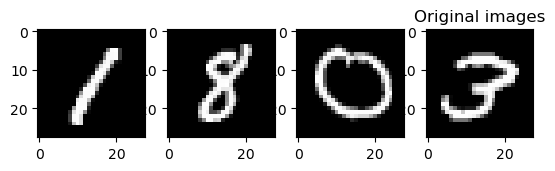

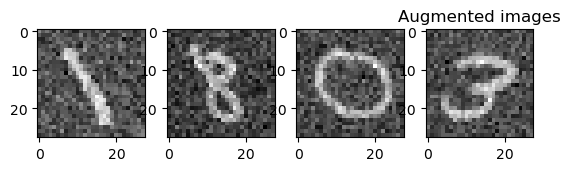

In [164]:
# Class for Gaussian noise
class GaussianNoise:
    def __init__(self, mean = 0.0, std = 0.5 ):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# The amount of Gaussian noise to be added to the images can be controlled by changing the below mean and std
mean = 0.0
std = 0.2

# Tensor transform to add augmentations to training images
aug_transform = transforms.Compose([
    transforms.ToTensor(),
    v2.RandomHorizontalFlip(p = 0.7),
    GaussianNoise(mean, std),
    #v2.RandomVerticalFlip(p = 0.5),
])


mnist_train = datasets.MNIST(root='./data', train= True, download = True, transform = transforms.ToTensor())
# Generate augmented dataset
mnist_train_aug = datasets.MNIST(root='./data', train=True, download=True, transform = aug_transform) 


# Create dataset containing normal training images and augmented images
aug_dataset = mnist_train + mnist_train_aug
aug_train_data = DataLoader(dataset=aug_dataset, batch_size = 50, shuffle= True)


# Visualize random images from noisy dataset

fig, ax = plt.subplots(1, 4)
x, _ = mnist_train[3]
ax[0].imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_train[41]
ax[1].imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_train[108]
ax[2].imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_train[207]
ax[3].imshow(x.numpy()[0], cmap='gray')
plt.title('Original images')
plt.show()

fig, ax = plt.subplots(1, 4)
x, _ = mnist_train_aug[3]
ax[0].imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_train_aug[41]
ax[1].imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_train_aug[108]
ax[2].imshow(x.numpy()[0], cmap='gray')
x, _ = mnist_train_aug[207]
ax[3].imshow(x.numpy()[0], cmap='gray')
plt.title('Augmented images')
plt.show()

Step 2: Let us use a neural network with more hidden layers increasing the complexity of non-linearity  

In [175]:
#Define number of hidden layers
number_hidden_layers = 100

mlp = MultiLayerPerceptron(size_input = 28*28, size_hidden_layers = number_hidden_layers, classes = 10)

# Define loss function - CrossEntropyLoss() (CE loss function will take care of implementing softmax to outputs)
loss_function = neuralnet.CrossEntropyLoss() 

# Define optimizer
optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.01)

print("Model summary of improved MLP model")
MLP = MultiLayerPerceptron(size_input = 28*28, size_hidden_layers = number_hidden_layers, classes = 10).to(device)
print(summary(MLP, (batch_size, 28*28)))

Model summary of improved MLP model
Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [50, 10]                  --
├─Linear: 1-1                            [50, 100]                 78,500
├─ReLU: 1-2                              [50, 100]                 --
├─Linear: 1-3                            [50, 10]                  1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.98
Input size (MB): 0.16
Forward/backward pass size (MB): 0.04
Params size (MB): 0.32
Estimated Total Size (MB): 0.52


In [176]:
# Training the model 
epochs = 30

correct_predictions = 0
samples = 0
accuracies = []

for epoch in range(epochs):
    for i, (images, labels) in enumerate(aug_train_data):

        # flatten images 28x28 to 784x1
        images = images.reshape(-1, 28*28) 
        
        # Forward propogation
        outputs = mlp(images)
        loss = loss_function(outputs, labels)

        # Backward propogation
        
        # Clear out the gradients of all parameters accumulated by optimizer before next step
        optimizer.zero_grad()

        # Calculated the derivative of loss to be used for gradient descent
        loss.backward()

        # Update MLP parameters by gradient descent
        optimizer.step()

        # Get max value along the rows
        index, prediction = torch.max(outputs, 1)

        samples = samples + labels.shape[0]
        correct_predictions += (prediction == labels).sum().item()

    # Calculate accuracy for each epoch
    accuracy = (correct_predictions/ samples)*100
    accuracies.append(accuracy)
    # Print loss and accuracy    
    print(f'Epoch {epoch+1}, Loss (CE): {round(loss.item(), 5)}  Accuracy = {round(accuracy, 3)}')

avg_train_accuracy = round(np.mean(accuracies),3)

Epoch 1, Loss (CE): 0.3876  Accuracy = 89.856
Epoch 2, Loss (CE): 0.21845  Accuracy = 91.31
Epoch 3, Loss (CE): 0.23216  Accuracy = 91.962
Epoch 4, Loss (CE): 0.17303  Accuracy = 92.369
Epoch 5, Loss (CE): 0.37538  Accuracy = 92.638
Epoch 6, Loss (CE): 0.31666  Accuracy = 92.892
Epoch 7, Loss (CE): 0.18161  Accuracy = 93.06
Epoch 8, Loss (CE): 0.18729  Accuracy = 93.196
Epoch 9, Loss (CE): 0.20549  Accuracy = 93.317
Epoch 10, Loss (CE): 0.24427  Accuracy = 93.408
Epoch 11, Loss (CE): 0.05526  Accuracy = 93.488
Epoch 12, Loss (CE): 0.67418  Accuracy = 93.564
Epoch 13, Loss (CE): 0.05367  Accuracy = 93.636
Epoch 14, Loss (CE): 0.18359  Accuracy = 93.685
Epoch 15, Loss (CE): 0.0604  Accuracy = 93.74
Epoch 16, Loss (CE): 0.06024  Accuracy = 93.794
Epoch 17, Loss (CE): 0.16688  Accuracy = 93.841
Epoch 18, Loss (CE): 0.43467  Accuracy = 93.885
Epoch 19, Loss (CE): 0.01044  Accuracy = 93.921
Epoch 20, Loss (CE): 0.15997  Accuracy = 93.957
Epoch 21, Loss (CE): 0.05848  Accuracy = 93.99
Epoch 2

Testing the performance of imporved model

In [177]:
correct_predictions = 0
actual_labels = 0

for images, labels in test_data:
    # Flatten the pixel of test images
    images = images.reshape(-1, 28*28)

    # Predict output using trained model
    outputs = mlp(images)

    # Find loss
    loss = loss_function(outputs, labels)

    # Get max value along the rows
    index, prediction = torch.max(outputs, 1)

    actual_labels = actual_labels + labels.shape[0]
    correct_predictions += (prediction == labels).sum().item()

# Calculate test accuracy
accuracy = (correct_predictions/ actual_labels)*100
print(f'Testing accuracy = {round(accuracy,3)}  Loss (CE): {loss.item()}')

Testing accuracy = 94.95  Loss (CE): 0.28901511430740356


We can observe that the test accuracy of the model has increased considerably compared to the previous model once after we trained the model using augmented data and increasing number of hidden layers